In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import warnings
import os
warnings.filterwarnings("ignore")

In [3]:
## Extreme Sementic Analysis

In [4]:
ori = np.load('../Data-Driven Analysis/Result/DDPM + student-t Example 5/origin_data_unnorm_toyexample.npy')
gen = np.load('../Data-Driven Analysis/Result/DDPM + student-t Example 5/generate_data_unnorm_toyexample.npy')

## Disentangle Trajectory Visualization 

In [5]:
def plot_denoising_grid(ts, imgs, step_interval=50, include_last=True, save_path=None, reverse=True):
    ts = np.asarray(ts).astype(int)
    S, B, T, C = imgs.shape

    target_steps = list(range(int(ts.min()), int(ts.max()) + 1, step_interval))
    if include_last and (int(ts.max()) not in target_steps):
        target_steps.append(int(ts.max()))

    sel_idx = [int(np.argmin(np.abs(ts - s))) for s in target_steps]
    sel_steps = ts[sel_idx]

    # 倒序显示（t 大在上）
    if reverse:
        sel_idx = sel_idx[::-1]
        sel_steps = sel_steps[::-1]

    R = len(sel_idx)
    x = np.arange(T)

    # 先画网格
    fig, axes = plt.subplots(
        R, B,
        figsize=(B * 2.0, R * 1.6),
        sharex=True, sharey=True
    )
    if R == 1:
        axes = axes[None, :]

    # 先画完所有子图，再统一放“行标题”
    row_centers = []
    left_edges = []

    for r, (k, step) in enumerate(zip(sel_idx, sel_steps)):
        for b in range(B):
            y = imgs[k, b].mean(axis=-1)
            ax = axes[r, b]
            ax.plot(x, y, linewidth=1.0)
            ax.set_xticks([])
            ax.set_yticks([])
            if r == 0:
                ax.set_title(f"s{b}", fontsize=25)

        # 记录这一行第一个子图的位置（figure 坐标）
        pos = axes[r, 0].get_position()
        y_center = 0.5 * (pos.y0 + pos.y1)
        row_centers.append(y_center)
        left_edges.append(pos.x0)

    # 行标题放在“第 1 列子图左边一点点”，离图近但不遮挡
    # 让标题的右边缘对齐到子图左边缘（x0 - gap）
    gap = 0.012  # 越小越靠近图片
    x_text = max(0.001, min(left_edges) - gap)

    for r, step in enumerate(sel_steps):
        fig.text(
            x_text, row_centers[r],
            f"t={int(step)}",
            ha="right", va="center",
            fontsize=25
        )

    # 给左侧留一点点空间，避免大字号被裁剪
    plt.subplots_adjust(left=0.12, wspace=0.05, hspace=0.05)

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    return fig


def load_trace_npz_as_arrays(path):
    z = np.load(path, allow_pickle=False)
    ts = z["t"].astype(int)
    ts = np.sort(ts)

    imgs   = np.stack([z[f"img/{t}"]        for t in ts], axis=0)
    trends = np.stack([z[f"trend_cum/{t}"]  for t in ts], axis=0)
    seasons= np.stack([z[f"season_cum/{t}"] for t in ts], axis=0)

    return ts, imgs, trends, seasons

In [6]:
ts, imgs, trends, seasons = load_trace_npz_as_arrays("../Data-Driven Analysis/Result/DDPM + Student-t Example 3/trace_toyexample.npz")

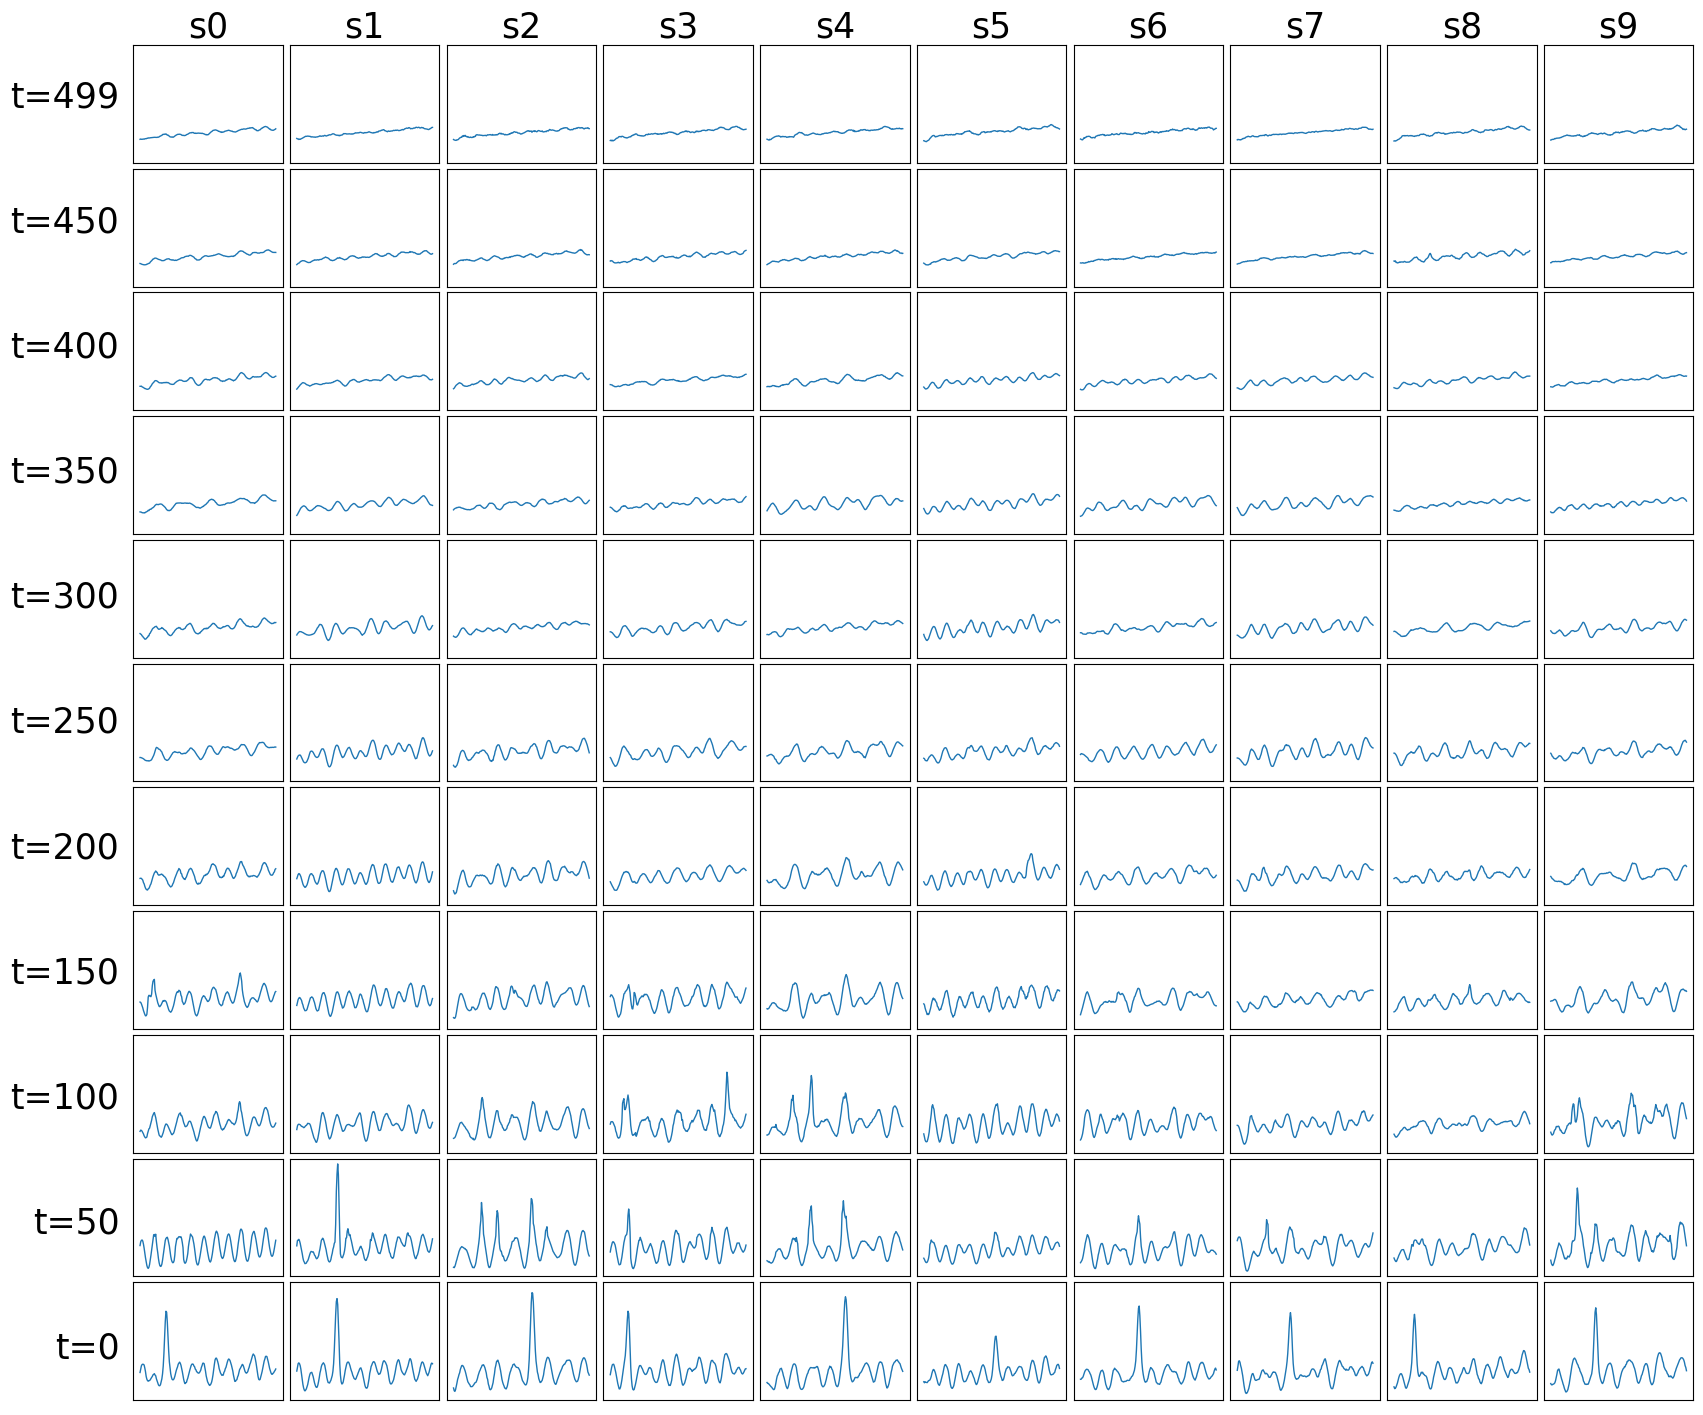

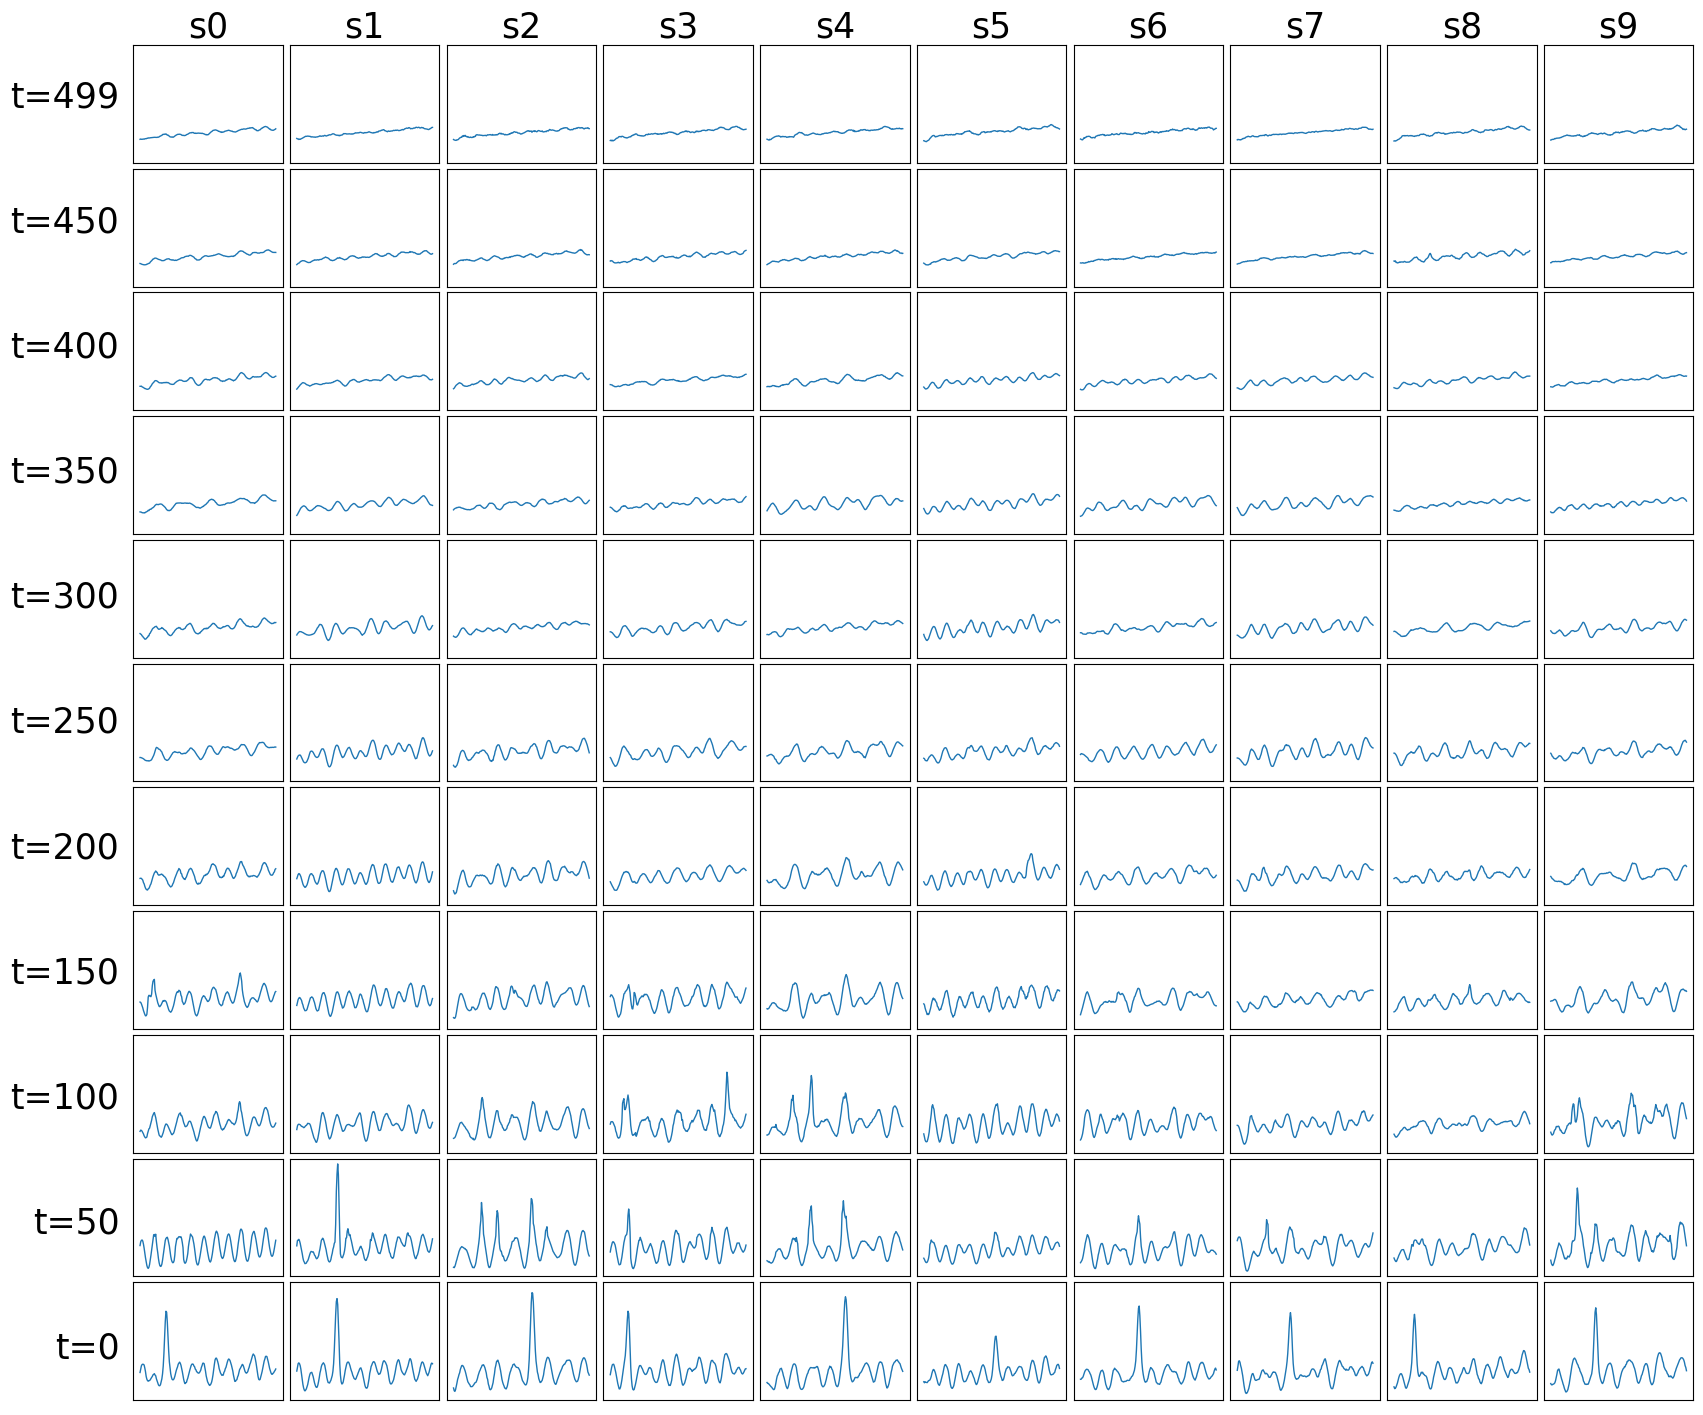

In [7]:
plot_denoising_grid(ts, imgs, step_interval=50, save_path="../Data-Driven Analysis/Plot/Overall Trajectory Visualization P.png")

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_one_step_one_fig_fixed_canvas_manual(
    ts, arr, steps, s=0,
    prefix="imgs",
    out_dir="fig",
    dpi=200,
    ylabel="value",
    fontsize=30,
    linewidth=1.2,
    x_tick_step=50,
    y_tick_step=0.1,
    show_yaxis_first_only=True,
    fig_size=(6, 4),
    # ---- 手动固定 margins（重点调这四个）----
    left=0.28,
    right=0.98,
    bottom=0.26,
    top=0.98,
    show=False,
):
    """
    目标：
    - 所有 PNG 外边界一致（像素尺寸一致）：fig_size + 不用 bbox_inches="tight"
    - 内部方框一致：subplots_adjust 固定
    - 仅第一张显示 y 轴：其余隐藏（但仍保留相同 left margin）
    - 不裁文字：把 left/bottom 设大一点（fontsize=30 通常需要 0.26~0.32）
    """
    ts = np.asarray(ts).astype(int)
    a = np.asarray(arr)
    if a.ndim == 3:
        a = a[..., None]
    elif a.ndim != 4:
        raise ValueError(f"arr must be 3D or 4D, got shape {a.shape}")

    S, B, T, C = a.shape
    if not (0 <= s < B):
        raise ValueError(f"s out of range: s={s}, B={B}")

    steps = [int(t) for t in steps]
    sel_idx = [int(np.argmin(np.abs(ts - t))) for t in steps]

    # ---- 全局 y 轴范围（共用）----
    ys = []
    for k in sel_idx:
        y = a[k, s].mean(axis=-1).astype(float) + 1.0
        ys.append(y)
    y_all = np.concatenate(ys, axis=0) if len(ys) else np.array([1.0], dtype=float)

    y_min = float(np.nanmin(y_all))
    y_max = float(np.nanmax(y_all))

    y0 = np.floor(y_min / y_tick_step) * y_tick_step
    y1 = np.ceil(y_max / y_tick_step) * y_tick_step
    if y1 <= y0:
        y1 = y0 + y_tick_step
    y_ticks = np.arange(y0, y1 + 0.5 * y_tick_step, y_tick_step)

    x = np.arange(T)
    x_ticks = np.arange(0, T + 1, x_tick_step)

    os.makedirs(out_dir, exist_ok=True)

    for i, (k, y) in enumerate(zip(sel_idx, ys)):
        step = int(ts[k])

        fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
        ax.plot(x, y, linewidth=linewidth)

        ax.set_xlabel(f"t = {step}", fontsize=fontsize)

        ax.set_xlim(-10, T + 10)
        ax.set_xticks(x_ticks)
        ax.tick_params(axis="x", labelsize=fontsize)

        ax.set_ylim(y0, y1)

        is_first = (i == 0)
        if (not show_yaxis_first_only) or is_first:
            ax.set_ylabel(ylabel, fontsize=fontsize + 5)
            ax.set_yticks(y_ticks)
            ax.tick_params(axis="y", labelsize=fontsize)
        else:
            ax.set_ylabel("")
            ax.set_yticks([])
            ax.tick_params(axis="y", left=False, labelleft=False)

        # ---- 关键：固定 margins（不要 tight_layout）----
        fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top)

        save_path = os.path.join(out_dir, f"{prefix}_s{s}_t{step}.png")
        # ---- 关键：不要 bbox_inches="tight"，否则外边界不一致 ----
        fig.savefig(save_path, dpi=dpi)

        if show:
            plt.show()
        plt.close(fig)

    return {"left": left, "right": right, "bottom": bottom, "top": top}


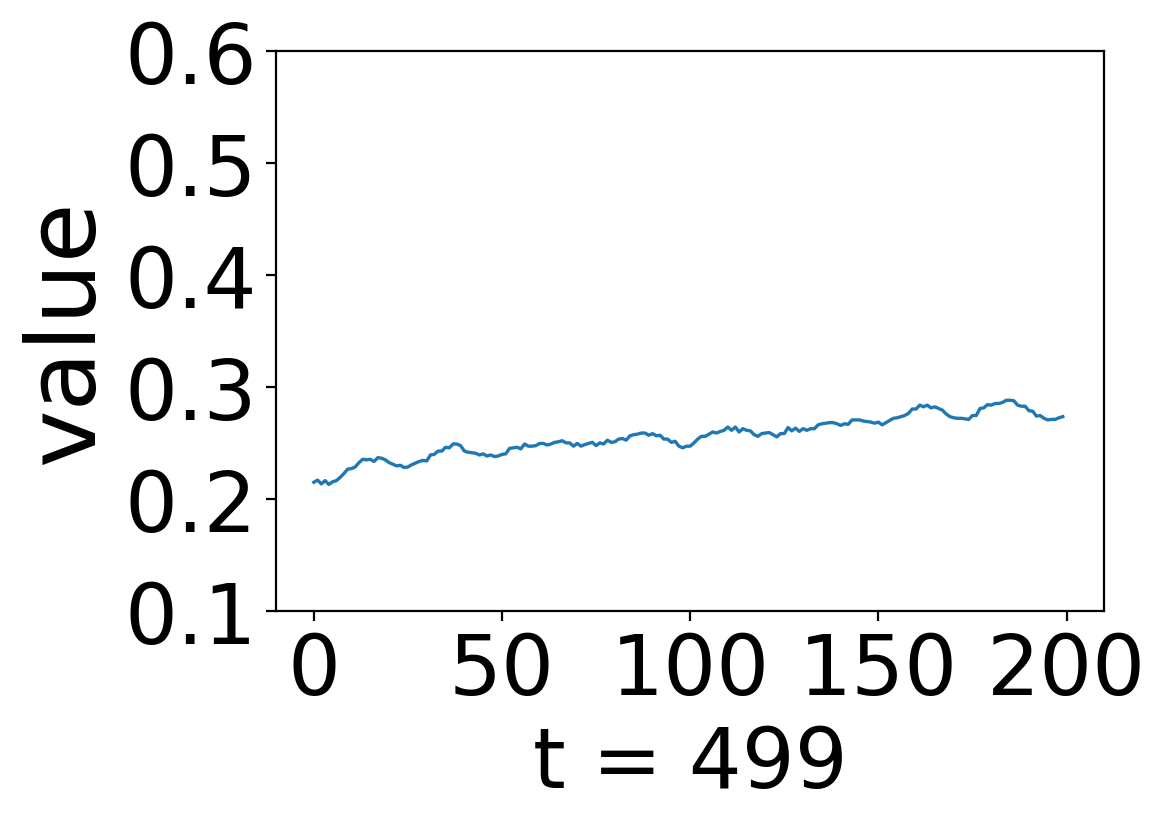

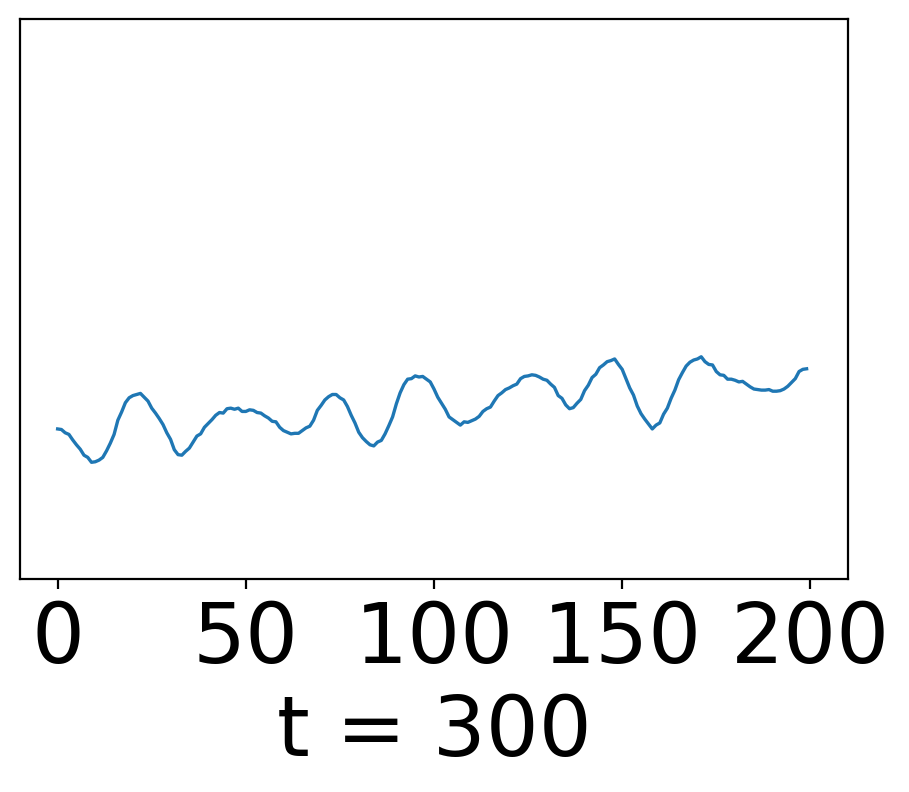

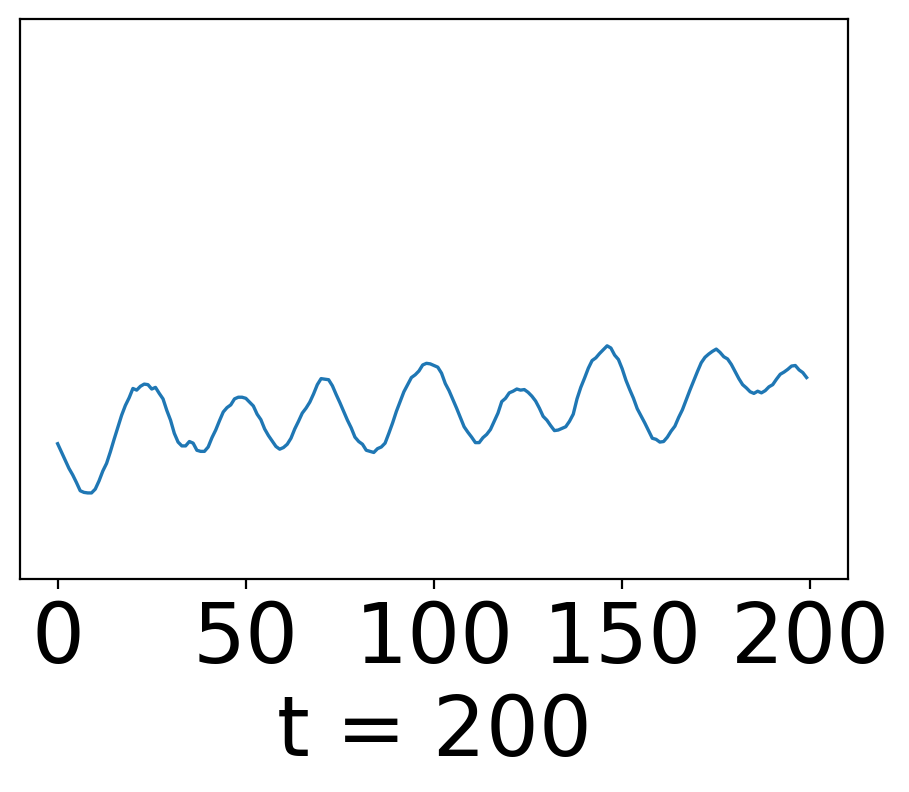

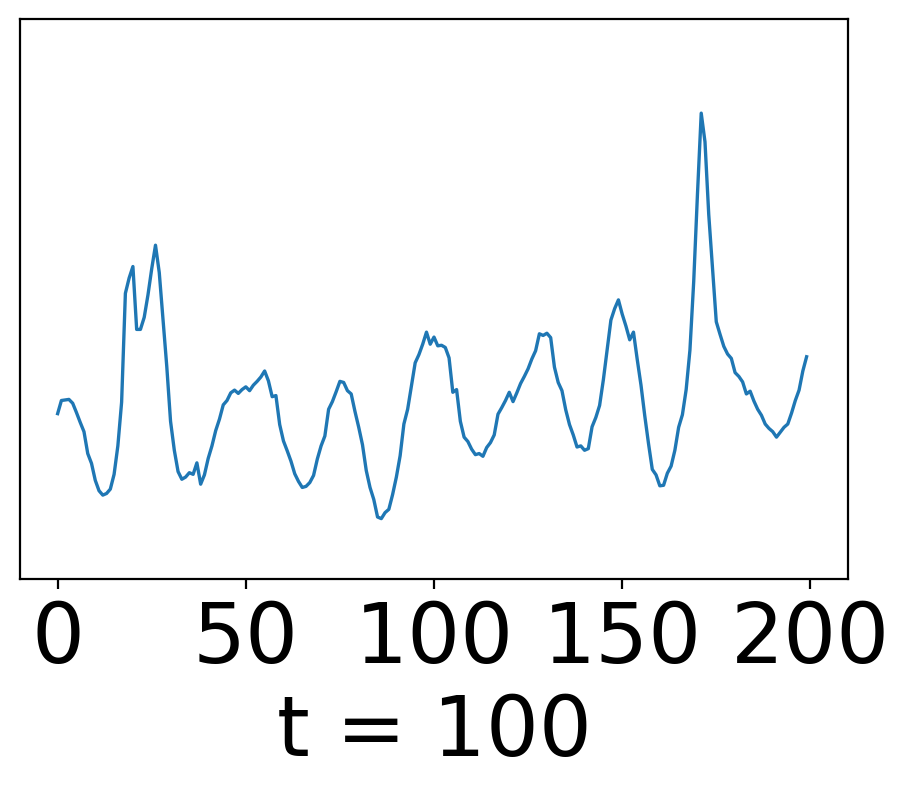

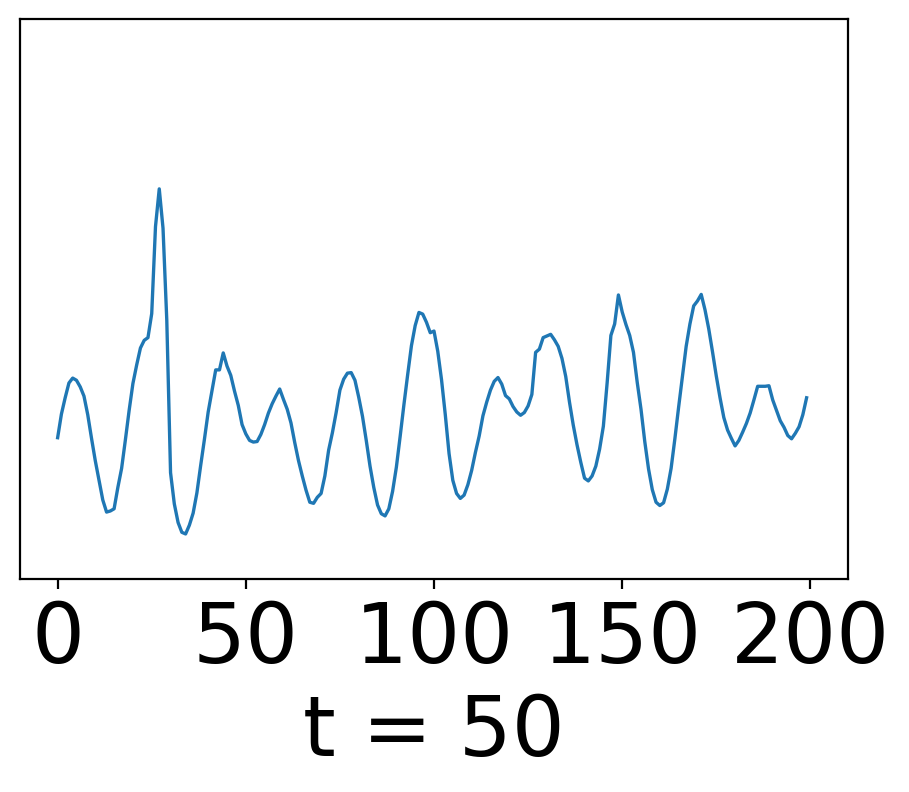

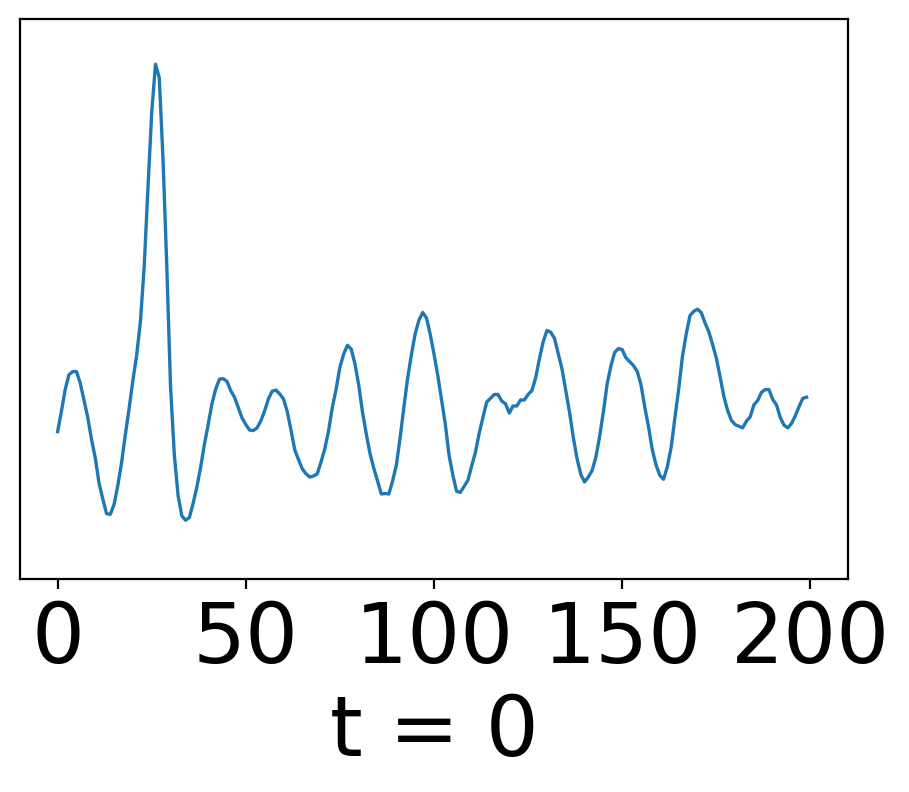

{'left': 0.28, 'right': 0.97, 'bottom': 0.26, 'top': 0.96}

In [24]:
plot_one_step_one_fig_fixed_canvas_manual(
    ts, imgs,
    steps=[499, 300, 200, 100, 50, 0],
    s=3,
    out_dir="../Data-Driven Analysis/Plot/",
    prefix="imgs",
    dpi=200,
    fontsize=30,
    show_yaxis_first_only=True,
    left=0.28,
    right=0.97,
    bottom=0.26,
    top=0.96,
    show=True,
)